# Statistical Analysis of Irrigation Values Inside and Outside Dam Command Areas (2000 & 2015)

This notebook performs descriptive statistics, visualizations, and hypothesis testing on irrigation pixel values extracted from inside and outside dam command areas for the years 2000 and 2015. The analysis follows advisor feedback and is structured as follows:

**Outline:**
1. Data Loading
2. Descriptive Statistics
3. Distribution Visualization
4. Statistical Hypothesis Testing

---

In [39]:
# Task 1: Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from scipy.stats import mannwhitneyu, ttest_ind
import os
from rasterio.crs import CRS
from rasterio.mask import mask

import sys
from tqdm import tqdm
import warnings 
from IPython.display import display, Markdown
from itertools import product
warnings.filterwarnings('ignore')

# Add the project root to sys.path so we can import from Code.utils everywhere
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from Code.utils.utility import load_config, resolve_path, ssa_iso, africa_iso_countries, africa_iso_countries_filtered
from Code.utils.spatial_utility import load_raster_and_reproject, optimized_clip
import rasterio

# Load configuration
config = load_config()

# Load the four CSV files using resolve_path and config (for consistency with project I/O)
# Load irrigation data for years 1980, 1985, 1990, 1995, 2000, 2015 from .tiff files

years = [2000]
irrigation_arrays = {}
for year in years:
    key = f'Irrigation_Arid_SSA_{year}_tif_path'
    path = resolve_path(config[key])
    with rasterio.open(path) as src:
        irrigation_arrays[year] = src.read(1)  # Read first band as numpy array
    print(f'Data for year {year} loaded from {path}, sample rows: {irrigation_arrays[year][:3]}')


ImportError: cannot import name 'load_raster_and_reproject' from 'Code.utils.spatial_utility' (/home/ermiller/Africa_Irrigation/Code/utils/spatial_utility.py)

In [ ]:
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
from rasterio.io import MemoryFile
from rasterio.mask import mask
from IPython.display import display, Markdown

ca_path = resolve_path(config['No_Crop_Vectorized_CA_UniLayer_shp_path'])
ca_gdf = gpd.read_file(ca_path)
if ca_gdf.crs != "EPSG:4326":
    ca_gdf = ca_gdf.to_crs("EPSG:4326")

results = []

for year in years:
    # Load and reproject raster to EPSG:4326
    raster_path = resolve_path(config[f'Irrigation_Arid_SSA_{year}_tif_path'])
    arr_reproj, transform, meta = load_raster_and_reproject(raster_path, dst_crs="EPSG:4326")
    
    meta.update({
        "height": arr_reproj.shape[0],
        "width": arr_reproj.shape[1],
        "transform": transform,
        "crs": "EPSG:4326",
        "count": 1,
        "dtype": arr_reproj.dtype
    })
    
    with MemoryFile() as memfile:
        with memfile.open(**meta) as src:
            src.write(arr_reproj, 1)
            
            # Mask inside command areas
            inside_mask, _ = mask(src, ca_gdf.geometry, crop=False, filled=True, nodata=src.nodata, invert=False)
            inside_pixels = inside_mask[0]
            inside_pixels = inside_pixels[(inside_pixels != src.nodata) & (inside_pixels != -9)]

            # Mask outside command areas (invert=True)
            outside_mask, _ = mask(src, ca_gdf.geometry, crop=False, filled=True, nodata=src.nodata, invert=True)
            outside_pixels = outside_mask[0]
            outside_pixels = outside_pixels[(outside_pixels != src.nodata) & (outside_pixels != -9)]
            
            # Total irrigation value from original array
            all_valid_pixels = arr_reproj[(arr_reproj != src.nodata) & (arr_reproj != -9)]

            results.append({
                'Year': year,
                'Total Inside': np.nansum(inside_pixels),
                'Total Outside': np.nansum(outside_pixels),
                'Total (Check)': np.nansum(all_valid_pixels),
                'Inside + Outside == Total': np.isclose(
                    np.nansum(inside_pixels) + np.nansum(outside_pixels),
                    np.nansum(all_valid_pixels),
                    atol=1e-3
                )
            })

results_df = pd.DataFrame(results)
display(Markdown("### Fractional Pixel-Weighted Analysis Results"))
display(results_df)


TypeError: load_and_reproject() got an unexpected keyword argument 'dst_crs'

### Descriptive Statistics
For each group (inside/outside, 2000/2015), we calculate mean, median, standard deviation, variance, min, max, and quartiles. Variance is highlighted as a key metric.

In [3]:
def print_descriptive_stats(df, label):
    desc = df['irrigation_value'].describe(percentiles=[0.25, 0.75])
    variance = df['irrigation_value'].var()
    print(f'--- Descriptive Statistics for {label} ---')
    print(f'Mean: {desc["mean"]:.4f}')
    print(f'Median: {desc["50%"]:.4f}')
    print(f'Std Dev: {desc["std"]:.4f}')
    print(f'Variance: {variance:.4f}')
    print(f'Min: {desc["min"]:.4f}')
    print(f'Q1 (25th): {desc["25%"]:.4f}')
    print(f'Q3 (75th): {desc["75%"]:.4f}')
    print(f'Max: {desc["max"]:.4f}')
    print()

for year in years:
    irrigation_data = irrigation_arrays[year]
    # Create a DataFrame for the year
    df = pd.DataFrame({
        'irrigation_value': irrigation_data.flatten()
    })
    
    # Print descriptive statistics
    print_descriptive_stats(df, f'Irrigation Data {year}')

--- Descriptive Statistics for Irrigation Data 2000 ---
Mean: 2.1338
Median: -9.0000
Std Dev: 145.8092
Variance: 21260.3379
Min: -9.0000
Q1 (25th): -9.0000
Q3 (75th): 0.0000
Max: 7504.1328



Filter for nonzero irrigation pixels

In [8]:
irrigation_valid = {}
irrigation_nz = {}
irrigation_zero = {}

for year in years:
    arr = irrigation_arrays[year]
    valid = arr[arr != -9]
    irrigation_valid[year] = valid
    print(f'Valid (non -9) irrigation values for {year}: {len(valid)}')
    nz = valid[valid != 0]
    irrigation_nz[year] = nz
    print(f'Non-zero irrigation values for {year}: {len(nz)}')
    zero = valid[valid == 0]
    irrigation_zero[year] = zero
    print(f'Zero irrigation values for {year}: {len(zero)}')



Valid (non -9) irrigation values for 2000: 186148
Non-zero irrigation values for 2000: 11976
Zero irrigation values for 2000: 174172


Table summarizing the mean, median, and variance for each group (inside/outside, 2000/2015, and nonzero pixels)

In [11]:
# Table of summary statistics
def summary_table():
    summary = []
    for year in years:
        valid = irrigation_valid[year]
        nz = irrigation_nz[year]
        zero = irrigation_zero[year]
        summary.append({
            'Year': year,
            'Valid Count': len(valid),
            'Non-Zero Count': len(nz),
            'Zero Count': len(zero),
            'Mean': np.mean(valid) if len(valid) > 0 else np.nan,
            'Median': np.median(valid) if len(valid) > 0 else np.nan,
            'Std Dev': np.std(valid) if len(valid) > 0 else np.nan
        })
    return pd.DataFrame(summary)
display(Markdown("### Summary Statistics Table"))
summary_df = summary_table()
display(summary_df)
    

### Summary Statistics Table

,Year,Valid Count,Non-Zero Count,Zero Count,Mean,Median,Std Dev
0,2000,186148,11976,174172,27.944752,0.0,264.278717


### Distribution Visualization
Plot histograms and KDEs for inside and outside groups for each year. Both distributions are shown on the same axes for direct comparison.

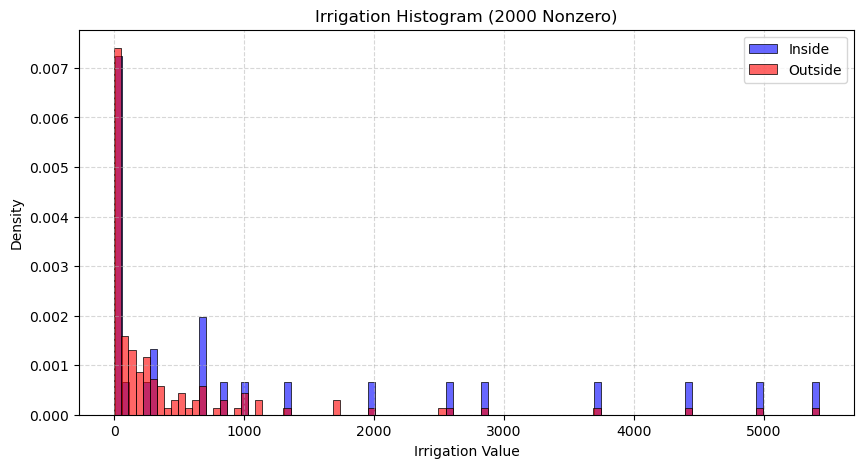

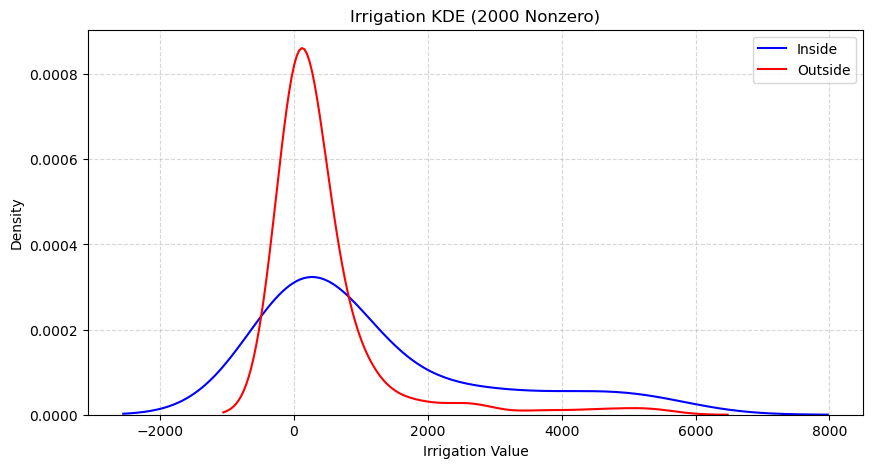

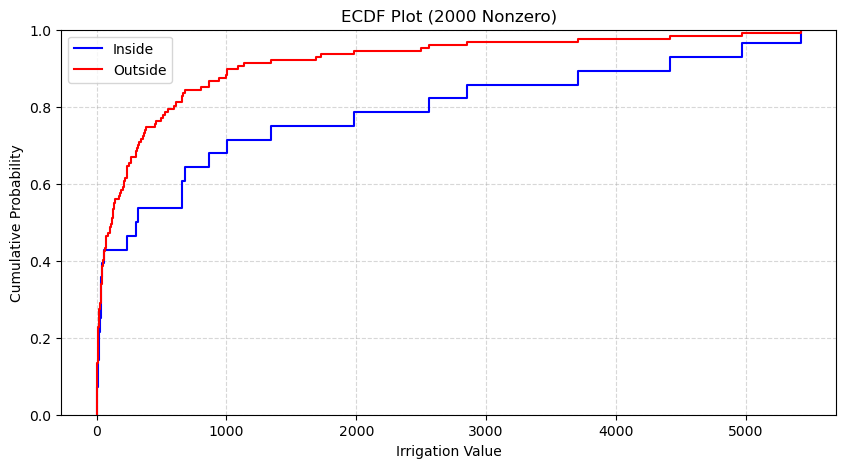

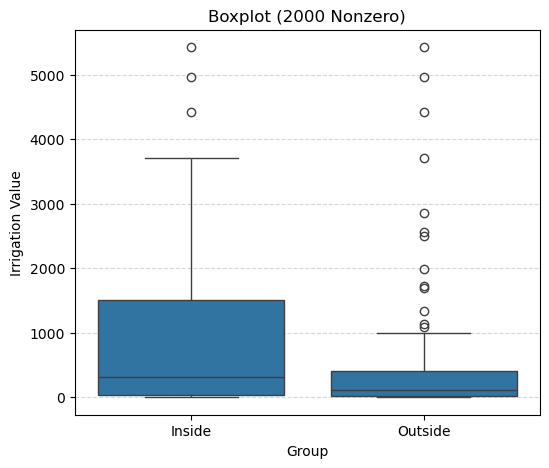

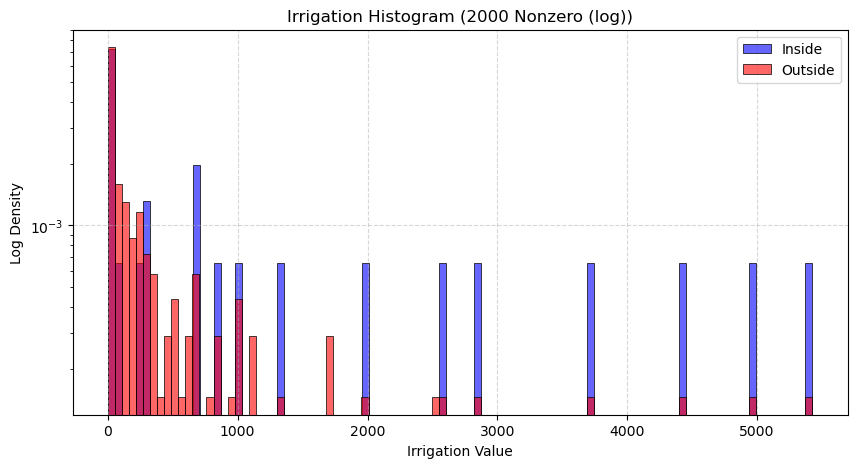

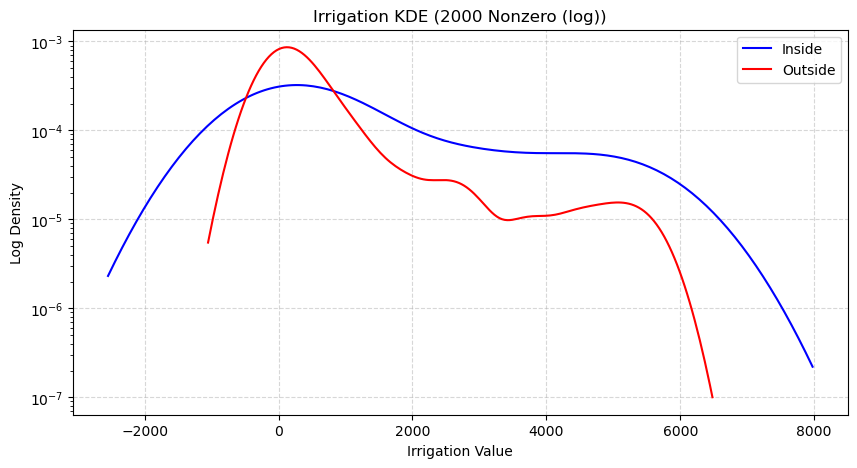

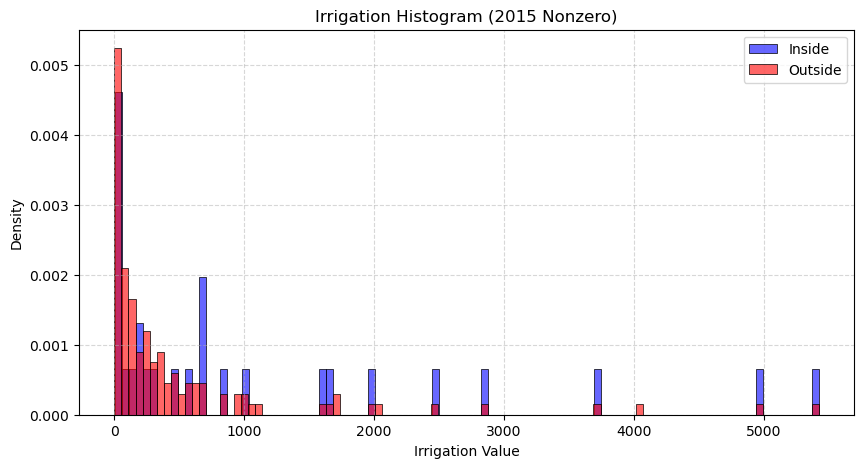

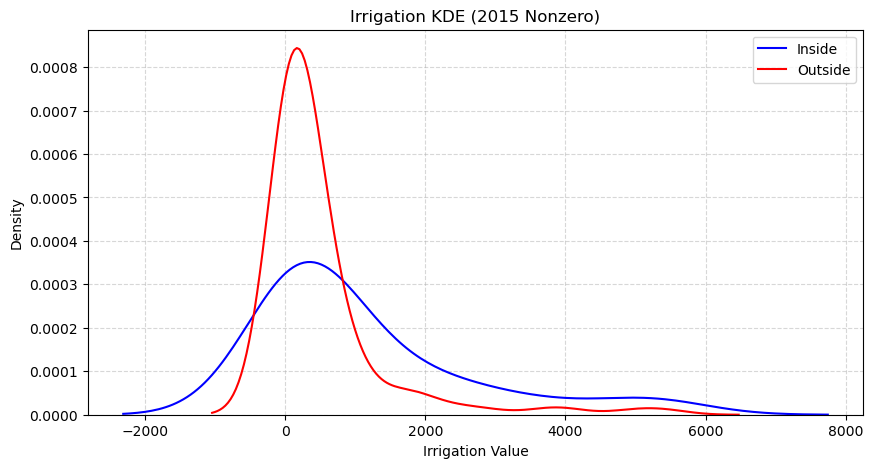

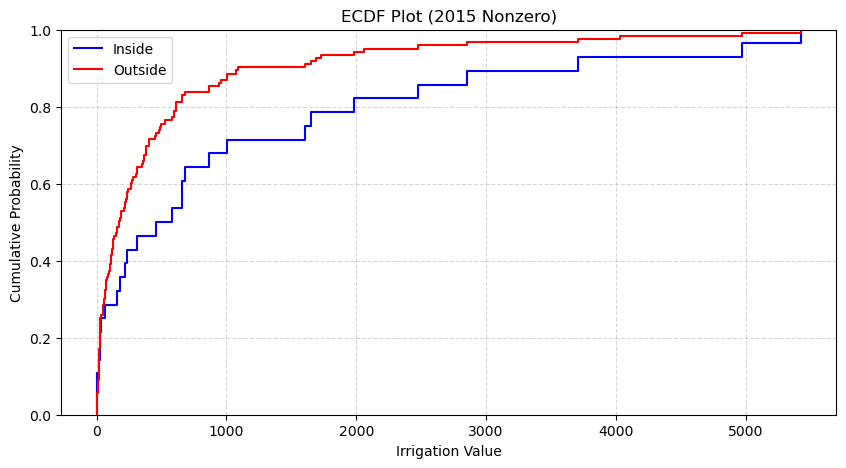

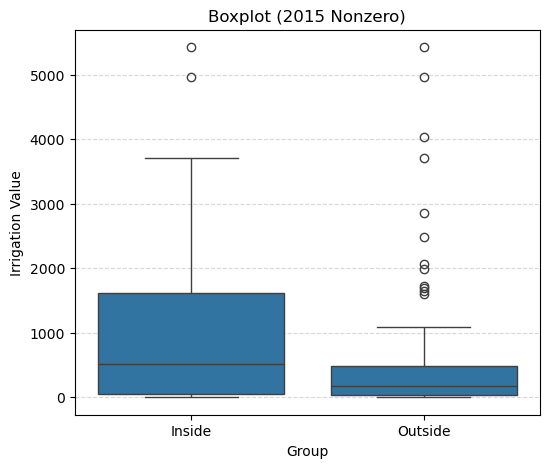

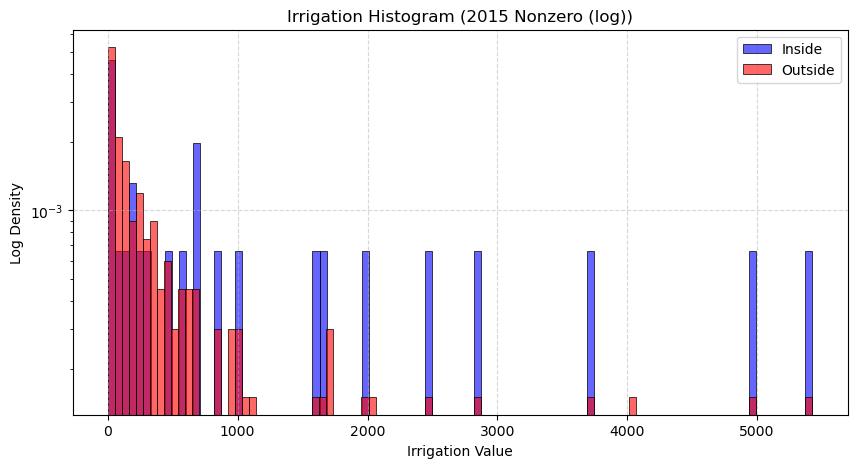

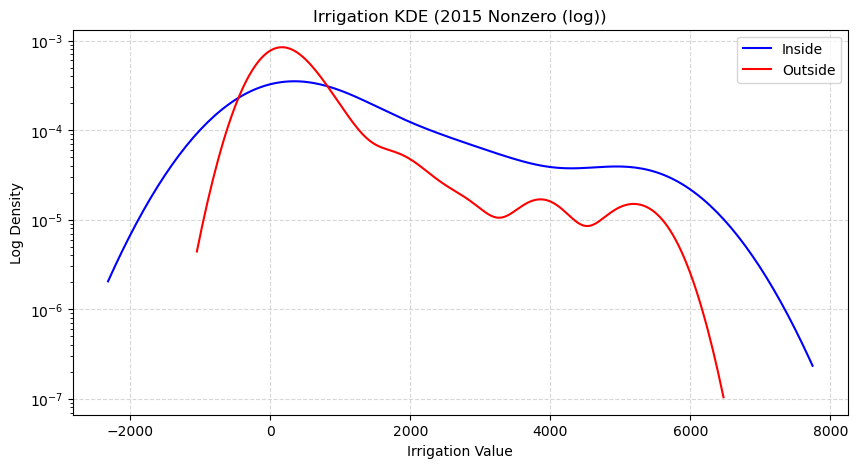

In [5]:
# Histogram Plot
def plot_histogram(df_in, df_out, label, log_scale=False):
    plt.figure(figsize=(10, 5))
    sns.histplot(df_in['irrigation_value'], stat="density", bins=100, color='blue', label='Inside', alpha=0.6)
    sns.histplot(df_out['irrigation_value'], stat="density", bins=100, color='red', label='Outside', alpha=0.6)
    plt.title(f'Irrigation Histogram ({label})')
    plt.xlabel("Irrigation Value")
    plt.ylabel("Density" if not log_scale else "Log Density")
    plt.legend()
    if log_scale:
        plt.yscale("log")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# KDE Plot
def plot_kde(df_in, df_out, label, log_scale=False):
    plt.figure(figsize=(10, 5))
    sns.kdeplot(df_in['irrigation_value'], label='Inside', color='blue')
    sns.kdeplot(df_out['irrigation_value'], label='Outside', color='red')
    plt.title(f'Irrigation KDE ({label})')
    plt.xlabel("Irrigation Value")
    plt.ylabel("Density" if not log_scale else "Log Density")
    plt.legend()
    if log_scale:
        plt.yscale("log")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# ECDF Plot
def plot_ecdf(df_in, df_out, label):
    plt.figure(figsize=(10, 5))
    sns.ecdfplot(df_in['irrigation_value'], label='Inside', color='blue')
    sns.ecdfplot(df_out['irrigation_value'], label='Outside', color='red')
    plt.title(f'ECDF Plot ({label})')
    plt.xlabel("Irrigation Value")
    plt.ylabel("Cumulative Probability")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# Boxplot
def plot_boxplot(df_in, df_out, label):
    combined_df = pd.concat([
        df_in.assign(Group='Inside'),
        df_out.assign(Group='Outside')
    ])
    plt.figure(figsize=(6, 5))
    sns.boxplot(data=combined_df, x='Group', y='irrigation_value')
    plt.title(f'Boxplot ({label})')
    plt.ylabel("Irrigation Value")
    plt.grid(True, axis='y', linestyle="--", alpha=0.5)
    plt.show()

# === 2000 Nonzero ===
plot_histogram(inside_2000_nz, outside_2000_nz, "2000 Nonzero", log_scale=False)
plot_kde(inside_2000_nz, outside_2000_nz, "2000 Nonzero", log_scale=False)
plot_ecdf(inside_2000_nz, outside_2000_nz, "2000 Nonzero")
plot_boxplot(inside_2000_nz, outside_2000_nz, "2000 Nonzero")

# Optional: log-scaled versions (helpful to highlight heavy tails)
plot_histogram(inside_2000_nz, outside_2000_nz, "2000 Nonzero (log)", log_scale=True)
plot_kde(inside_2000_nz, outside_2000_nz, "2000 Nonzero (log)", log_scale=True)
# plot_ecdf(inside_2000_nz, outside_2000_nz, "2000 Nonzero (log)")  # often redundant
# plot_boxplot(inside_2000_nz, outside_2000_nz, "2000 Nonzero (log)")  # redundant

# === 2015 Nonzero ===
plot_histogram(inside_2015_nz, outside_2015_nz, "2015 Nonzero", log_scale=False)
plot_kde(inside_2015_nz, outside_2015_nz, "2015 Nonzero", log_scale=False)
plot_ecdf(inside_2015_nz, outside_2015_nz, "2015 Nonzero")
plot_boxplot(inside_2015_nz, outside_2015_nz, "2015 Nonzero")

# Optional: log-scaled versions
plot_histogram(inside_2015_nz, outside_2015_nz, "2015 Nonzero (log)", log_scale=True)
plot_kde(inside_2015_nz, outside_2015_nz, "2015 Nonzero (log)", log_scale=True)
# plot_ecdf(inside_2015_nz, outside_2015_nz, "2015 Nonzero (log)")
# plot_boxplot(inside_2015_nz, outside_2015_nz, "2015 Nonzero (log)")

# === Optional: All-pixel comparisons ===
# These are noisier due to many zeros and were deemed less informative

# plot_histogram(inside_2000, outside_2000, "2000", log_scale=False)
# plot_kde(inside_2000, outside_2000, "2000", log_scale=False)
# plot_ecdf(inside_2000, outside_2000, "2000")
# plot_boxplot(inside_2000, outside_2000, "2000")

# plot_histogram(inside_2015, outside_2015, "2015", log_scale=False)
# plot_kde(inside_2015, outside_2015, "2015", log_scale=False)
# plot_ecdf(inside_2015, outside_2015, "2015")
# plot_boxplot(inside_2015, outside_2015, "2015")



### Statistical Hypothesis Testing
We use the Mann-Whitney U test to formally compare the distributions of irrigation values inside and outside polygons for each year.

**Null Hypothesis (H0):** The distributions of irrigation values inside and outside polygons are the same.

**Alternative Hypothesis (Ha):** The distributions are different.

In [6]:
def cliffs_delta(a, b):
    n1, n2 = len(a), len(b)
    greater = sum(x > y for x, y in product(a, b))
    less = sum(x < y for x, y in product(a, b))
    return (greater - less) / (n1 * n2)

def run_tests_with_summary(df_in, df_out, label):
    mw_u, mw_p = mannwhitneyu(df_in['irrigation_value'], df_out['irrigation_value'], alternative='two-sided')
    t_stat, t_p = ttest_ind(df_in['irrigation_value'], df_out['irrigation_value'], equal_var=False)
    delta = cliffs_delta(df_in['irrigation_value'], df_out['irrigation_value'])
    conclusion = "Statistically significant" if mw_p < 0.05 or t_p < 0.05 else "No significant difference"
    
    # Console output
    print(f'--- {label} ---')
    print(f'Mann–Whitney U: U={mw_u:.2f}, p={mw_p:.4f}')
    print(f'T-test: t={t_stat:.2f}, p={t_p:.4f}')
    print(f"Cliff's delta: {delta:.4f}")
    print("Conclusion:", conclusion, "\n")

# Run tests and print summaries for all pairs
pairs = [
    (inside_2000, outside_2000, "2000 (All Pixels)"),
    (inside_2015, outside_2015, "2015 (All Pixels)"),
    (inside_2000_nz, outside_2000_nz, "2000 (Nonzero Pixels)"),
    (inside_2015_nz, outside_2015_nz, "2015 (Nonzero Pixels)")
]

for df_in, df_out, label in pairs:
    run_tests_with_summary(df_in, df_out, label)



--- 2000 (All Pixels) ---
Mann–Whitney U: U=160619.00, p=0.0000
T-test: t=2.72, p=0.0072
Cliff's delta: 0.1309
Conclusion: Statistically significant 

--- 2015 (All Pixels) ---
Mann–Whitney U: U=160935.50, p=0.0000
T-test: t=2.77, p=0.0063
Cliff's delta: 0.1331
Conclusion: Statistically significant 

--- 2000 (Nonzero Pixels) ---
Mann–Whitney U: U=2151.00, p=0.0832
T-test: t=2.15, p=0.0395
Cliff's delta: 0.2098
Conclusion: Statistically significant 

--- 2015 (Nonzero Pixels) ---
Mann–Whitney U: U=2121.50, p=0.0561
T-test: t=2.03, p=0.0510
Cliff's delta: 0.2320
Conclusion: No significant difference 

